In [1]:
# !pip install ../input/keras-application/Keras_Applications-1.0.8-py3-none-any.whl

In [2]:
# !pip install ../input/efficientnet111/efficientnet-1.1.1-py3-none-any.whl

In [3]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

Tensorflow version 2.4.0


In [4]:
import tensorflow_addons as tfa

In [5]:
plt.rcParams["figure.figsize"] = (12,12)

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH_ORI = '../MobileNet/full_res_TFRecords'
# GCS_PATH_NEW = KaggleDatasets().get_gcs_path('cldc-ds-1121-size-512')
GCS_PATH_NEW = '../MobileNet/full_res_TFRecords'# KaggleDatasets().get_gcs_path('cassavafullrestfrecords')
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
# IMAGE_SIZE = [600, 800]
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)
EPOCHS = 20

In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.int32)# / 255.0
    return image

def read_tfrecord(example, labeled=True):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example["image"])
    
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [9]:
# GCS_PATH_ORI = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')
# FILES = tf.io.gfile.glob(GCS_PATH_ORI + '/train_tfrecords/*.tfrec')

# GCS_PATH_ORI = KaggleDatasets().get_gcs_path('cassavafullrestfrecords')
FILES = tf.io.gfile.glob(GCS_PATH_ORI + '/Id_train*.tfrec')

In [10]:
FILENAMES = []

for f in FILES:
    if True:#'train18' not in f and 'train19' not in f:
        FILENAMES.append(f)
        

# [f for f in FILENAME if 'train18' is not in f ]

In [11]:
CHANNELS = 3

# ImageNet mean and standard deviation
# IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
# IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.uniform([1],dtype='float32') 
    width_shift = w_shift * tf.random.uniform([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape(tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def data_augment(image, label):
    
    HEIGHT = IMAGE_SIZE[0]
    WIDTH = IMAGE_SIZE[1]
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shift = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_hue = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Flips
    if p_spatial >= .5:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .50:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Crops
    if p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    elif p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
        
    # Pixel-level transforms
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=0., upper=0.5)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=0., upper=0.5)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.2)
#         else:
#             image = tf.image.adjust_gamma(image, gamma=.2)
    
    if p_hue >= 0.5:
        image = tf.image.random_hue(image, 0.3)

    return image, label

PROBABILITY = 0.75
AUG_BATCH=BATCH_SIZE

def cutmix(image, label):
#     print(label.shape)
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
#         if len(label.shape)==1:
#             lab1 = tf.one_hot(label[j],NUM_CLASSES)
#             lab2 = tf.one_hot(label[k],NUM_CLASSES)
#         else:
#             lab1 = label[j,]
#             lab2 = label[k,]
#         lab1 = tf.one_hot(label[j],NUM_CLASSES)
#         lab2 = tf.one_hot(label[k],NUM_CLASSES)
        lab1 = label[j,]
        lab2 = label[k,]
        
    
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
#     print(labs)
#     label2 = labs #tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,labs

In [12]:
def input_preprocess(image, label):
    image = tf.image.resize(image, size=IMAGE_SIZE, method='nearest')
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=255)
    image = tf.dtypes.cast(image, tf.uint8)
    # normalize according to imagenet mean and standard deviation
#     image /= 255.0
#     image = (image - IMAGENET_MEAN) / IMAGENET_STD
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def get_training_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.map(cutmix, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [13]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    FILENAMES,
    test_size=0.25, random_state=420
)

In [15]:
print("Validation data shapes:")
for image, label in get_validation_dataset(VALID_FILENAMES, BATCH_SIZE).take(3):
    print(image.numpy().shape, label.numpy().shape)

Validation data shapes:
(8, 512, 512, 3) (8, 5)
(8, 512, 512, 3) (8, 5)
(8, 512, 512, 3) (8, 5)


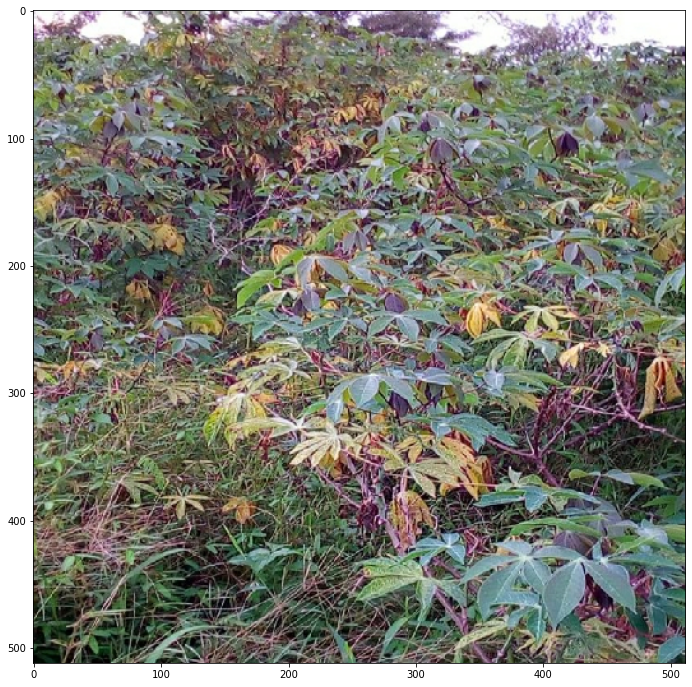

In [16]:
plt.imshow(image[3])

In [17]:
print("Training data shapes:")
for image, label in get_training_dataset(TRAINING_FILENAMES, BATCH_SIZE).take(3):
    print(image.numpy().shape, label.numpy().shape)

Training data shapes:
(8, 512, 512, 3) (8, 5)
(8, 512, 512, 3) (8, 5)
(8, 512, 512, 3) (8, 5)


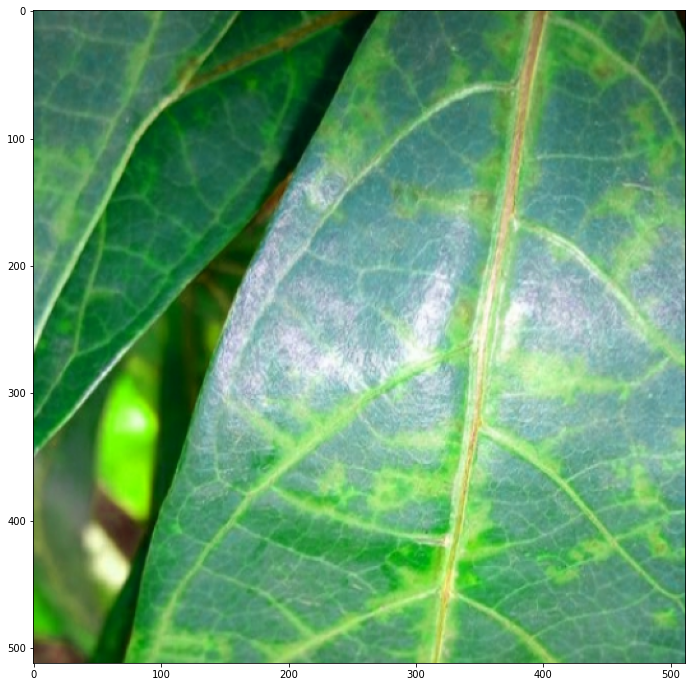

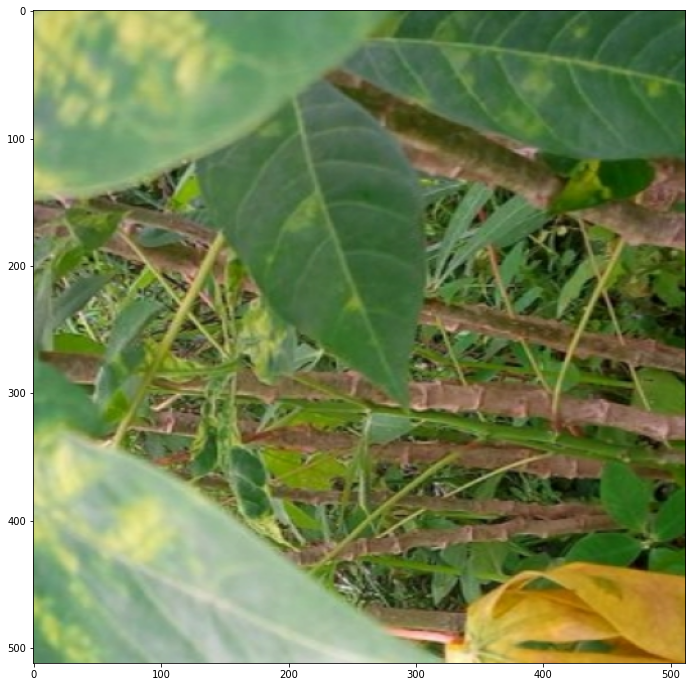

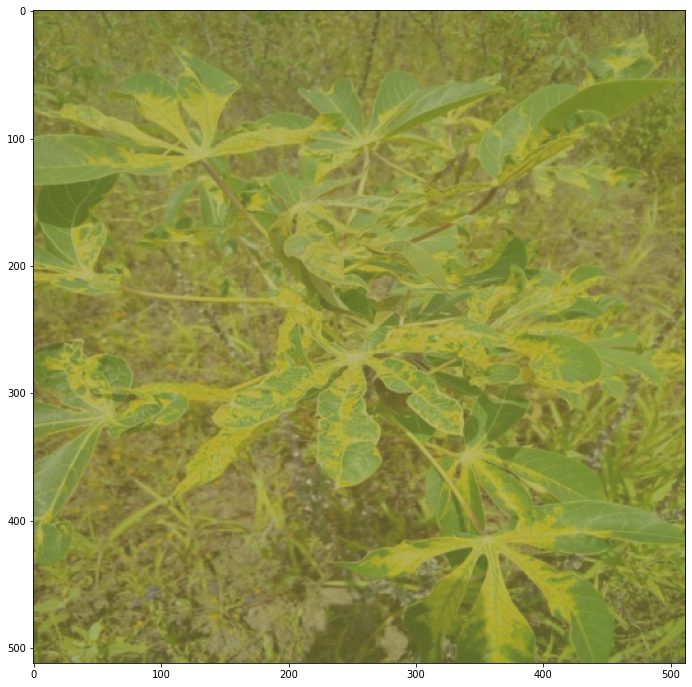

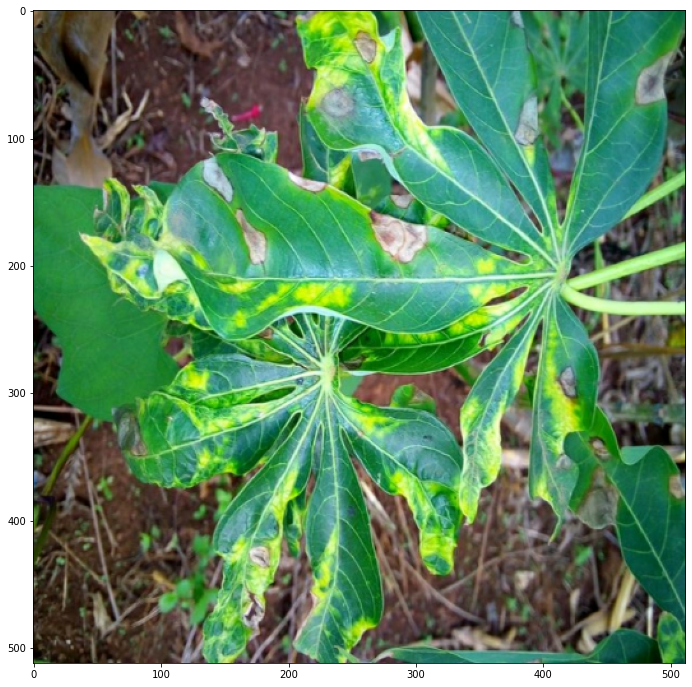

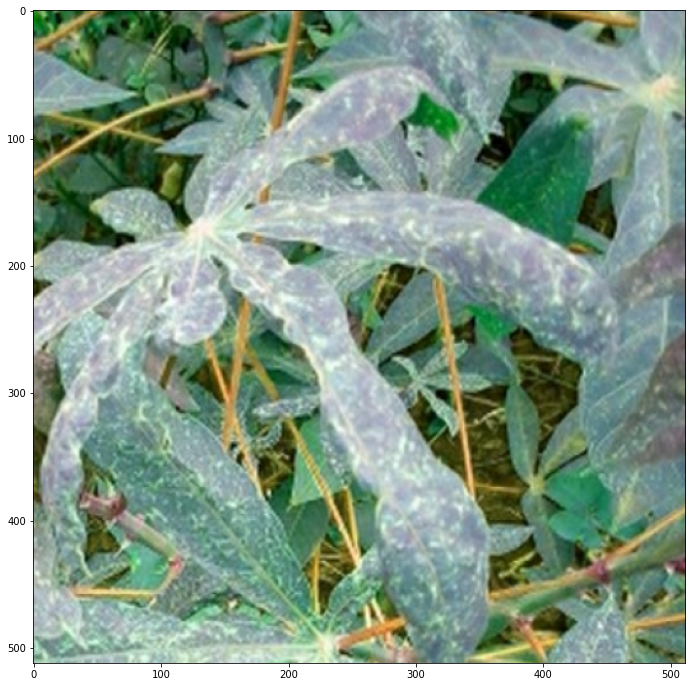

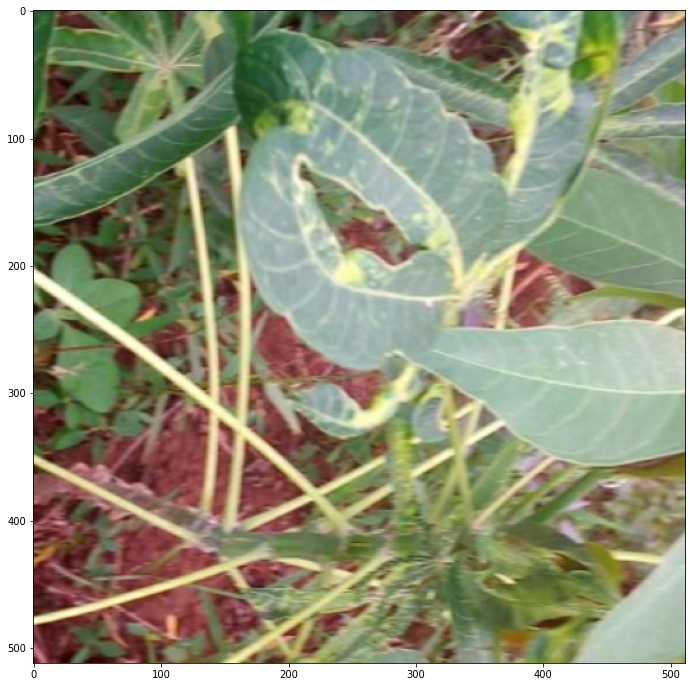

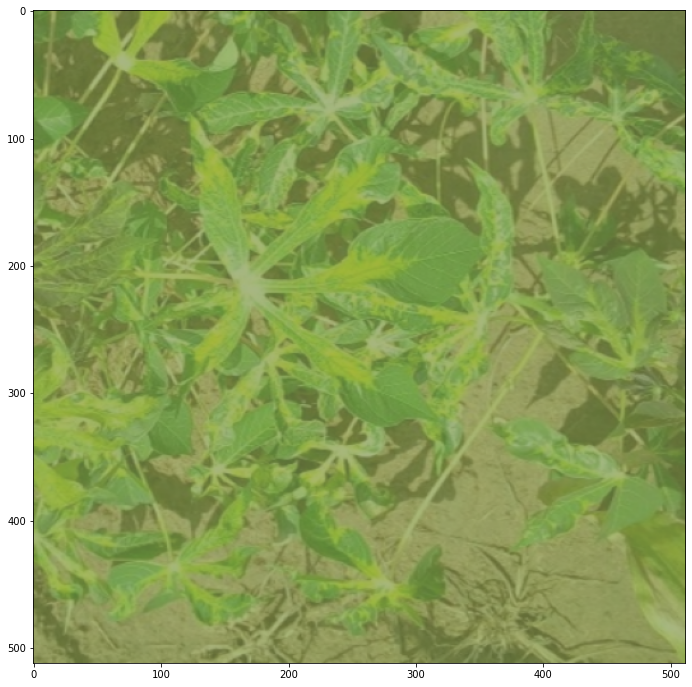

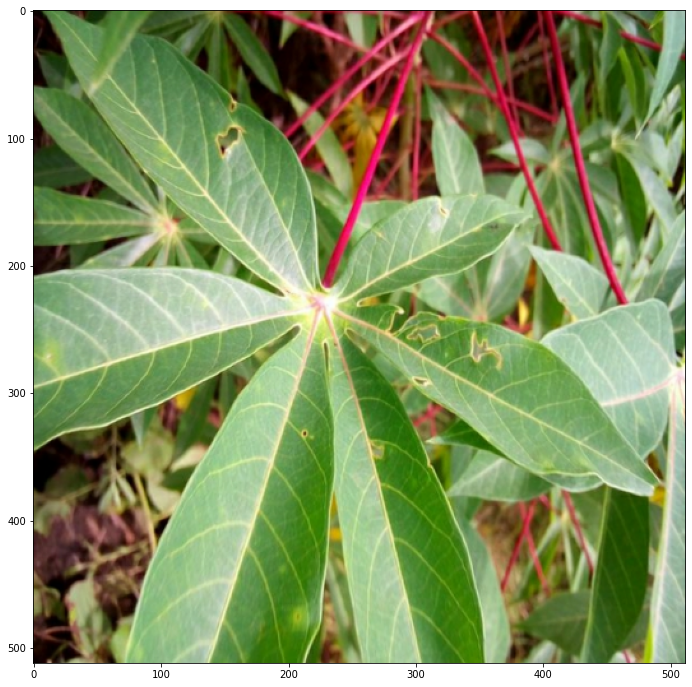

In [18]:
for i in range(BATCH_SIZE):
    plt.imshow(image[i])
    plt.show()

In [19]:
# from tensorflow.keras.experimental import CosineDecay
import efficientnet.keras as eff

In [20]:
# load data
train_dataset = get_training_dataset(TRAINING_FILENAMES, BATCH_SIZE)
valid_dataset = get_validation_dataset(VALID_FILENAMES, BATCH_SIZE)

In [21]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)

In [22]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 2
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [23]:
# with strategy.scope():
# #     pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
# #     pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
# #     pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
# #     pretrained_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
# #     pretrained_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False ,
# #                                                             input_shape=[*IMAGE_SIZE, 3])

# #     inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
# #     pretrained_model = eff.EfficientNetB4(include_top=False, input_tensor=inputs, 
# #                                           weights='noisy-student')
    
# #     inputs = tf.cast(inputs, tf.float32)
    
# #     inputs = tf.keras.applications.densenet.preprocess_input(
# #             inputs, data_format=None
# #     )
    
#     pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, 
#                                                          input_shape=[*IMAGE_SIZE, 3])
#     pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
    
#     model = tf.keras.Sequential([
#         pretrained_model,
# #         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.GlobalAveragePooling2D(),
# #         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.Dense(len(CLASSES), activation='softmax')
#     ])
    
#     loss = tf.keras.losses.CategoricalCrossentropy()
#     model.compile(
#     optimizer='Nadam',
#     loss = loss,
#     metrics=['accuracy']
#     )
    
#     model.summary()

In [24]:
# with strategy.scope():
#     inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
#     inputs = tf.cast(inputs, tf.float32)
    
#     inputs = tf.keras.applications.densenet.preprocess_input(
#             inputs
#     )
    
# #     inputs = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
# #     inputs = tf.cast(inputs, tf.float32)
# #     inputs = tf.keras.applications.mobilenet.preprocess_input(inputs)

#     model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, 
#                                                          input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

#     # Rebuild top
#     x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
#     x = tf.keras.layers.Dropout(0.3, name="top_dropout")(x)
#     # Freeze the pretrained weights
#     # model.trainable = False
#     outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

#     # Compile
# #     model = tf.keras.Model(inputs, outputs, name="EfficientNet")

In [25]:
with strategy.scope():
    i = tf.keras.layers.Input([IMAGE_SIZE[0], IMAGE_SIZE[1], 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.densenet.preprocess_input(x)
    core = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, 
                                                             input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = core(x)

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = tf.keras.layers.Dropout(0.3, name="top_dropout")(x)
    # Freeze the pretrained weights
    # model.trainable = False
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    model.compile(
    optimizer='Nadam',
    loss = loss,
    metrics=['accuracy']
    )
    
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 512, 512, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 512, 512, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 512, 512, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 512, 512, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1920)              0     

In [26]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks=[lr_callback], 
                   use_multiprocessing=True, workers=4)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
2005/2005 [==============================] - 1021s 482ms/step - loss: 1.0310 - accuracy: 0.5934 - val_loss: 0.4670 - val_accuracy: 0.8430
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 2e-05.
2005/2005 [==============================] - 961s 480ms/step - loss: 0.5889 - accuracy: 0.7870 - val_loss: 0.4160 - val_accuracy: 0.8630
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 3.0000000000000004e-05.
2005/2005 [==============================] - 963s 480ms/step - loss: 0.5507 - accuracy: 0.8100 - val_loss: 0.4256 - val_accuracy: 0.8613
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 4e-05.
2005/2005 [==============================] - 971s 484ms/step - loss: 0.5123 - accuracy: 0.8230 - val_loss: 0.4355 - val_accuracy: 0.8628
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 5e-05.
2005/2005 [=======================

In [27]:
# model.save('efficientnet-b0-8831.h5')